# MLC Leaf Detection and Analysis

Streamlined DICOM analysis for Multi-Leaf Collimator (MLC) quality assurance.

## 1. Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## 2. Load DICOM File and Extract Metadata

In [2]:
# Path to DICOM file
dicom_file = r'R:\RADIOTHERAPIE_SC_GENERAL\0 - TOP accelerateurs\05 UNITY\Hebdo_MLCprecision\CQMLCerreur\RTI00521.dcm'

# Load DICOM data
dicom_data = pydicom.dcmread(dicom_file)
image_array = dicom_data.pixel_array.astype(np.float32)

# Extract geometric parameters
SAD = float(dicom_data.RadiationMachineSAD)  # Source to Axis Distance (isocenter)
SID = float(dicom_data.RTImageSID)  # Source to Image Distance
scaling_factor = SAD / SID  # Geometric scaling factor for isocenter projection

# Extract pixel spacing
pixel_spacing = dicom_data.ImagePlanePixelSpacing
pixel_spacing_x = float(pixel_spacing[0])  # mm per pixel (X direction)
pixel_spacing_y = float(pixel_spacing[1])  # mm per pixel (Y direction)

# Extract RT Image Position (top-left corner in patient coordinates)
rt_image_position = dicom_data.RTImagePosition
rt_image_pos_x = float(rt_image_position[0])  # mm from patient origin (X)
rt_image_pos_y = float(rt_image_position[1])  # mm from patient origin (Y)

print("="*80)
print("DICOM METADATA")
print("="*80)
print(f"Image Shape: {image_array.shape}")
print(f"Pixel Spacing: {pixel_spacing_x} mm/px (X), {pixel_spacing_y} mm/px (Y)")
print(f"RT Image SID: {SID:.2f} mm")
print(f"Radiation SAD: {SAD:.2f} mm")
print(f"Scaling Factor (SAD/SID): {scaling_factor:.4f}")
print(f"RT Image Position: X={rt_image_pos_x} mm, Y={rt_image_pos_y} mm")
print("="*80)

DICOM METADATA
Image Shape: (1024, 1024)
Pixel Spacing: 0.4 mm/px (X), 0.4 mm/px (Y)
RT Image SID: 2657.80 mm
Radiation SAD: 1435.00 mm
Scaling Factor (SAD/SID): 0.5399
RT Image Position: X=-205.0 mm, Y=205.0 mm


## 3. Image Preprocessing

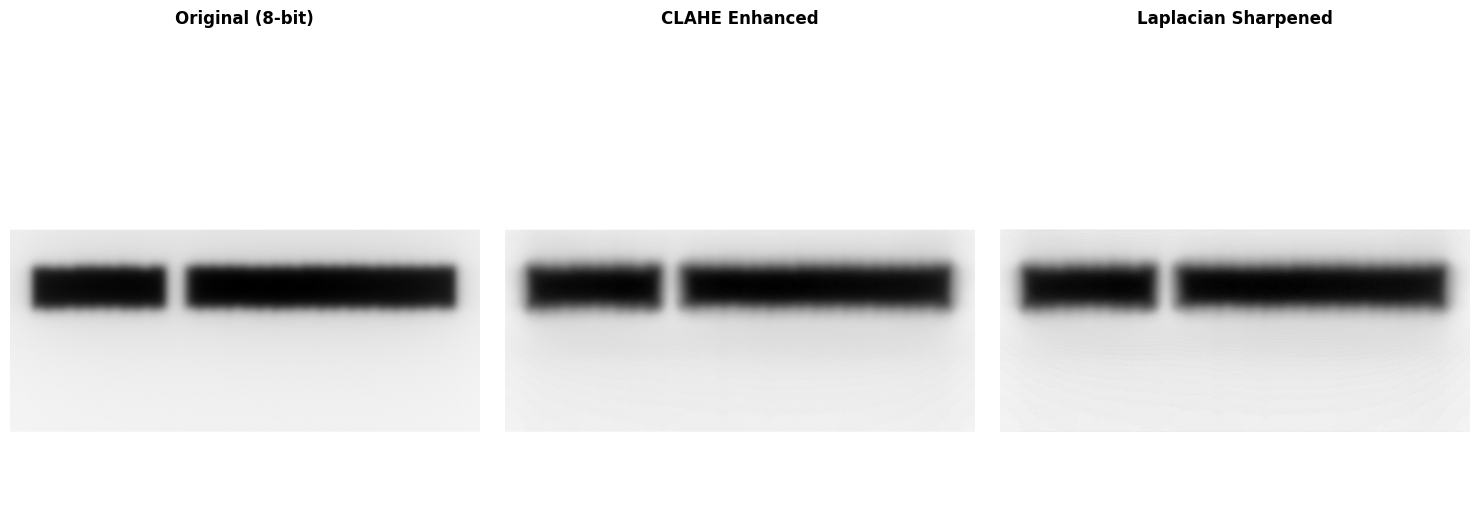

Preprocessing: Normalization → CLAHE → Laplacian Sharpening


In [3]:
# Normalize to 0-1 range
normalized_img = (image_array - image_array.min()) / (image_array.max() - image_array.min())

# Convert to 8-bit for OpenCV processing
img_8bit = cv2.normalize(normalized_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
ref_point_u = 511.03 -35
ref_point_v = 651.53
# cross_size = 12
# cross_color_ref = (0, 255, 0)  # Green for reference point M
    
# cv2.line(img_8bit, 
#             (int(ref_point_u) - cross_size, int(ref_point_v)), 
#             (int(ref_point_u) + cross_size, int(ref_point_v)), 
#             cross_color_ref, 1)
# cv2.line(img_8bit, 
#             (int(ref_point_u), int(ref_point_v) - cross_size), 
#             (int(ref_point_u), int(ref_point_v) + cross_size), 
#             cross_color_ref, 1)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img_8bit)

# Apply Laplacian sharpening
laplacian_kernel = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]], dtype=np.float32)
laplacian_sharpened = cv2.filter2D(clahe_img, -1, laplacian_kernel)
laplacian_sharpened = np.clip(laplacian_sharpened, 0, 255).astype(np.uint8)

# Display preprocessing results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_8bit, cmap='gray')
axes[0].set_title('Original (8-bit)', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(clahe_img, cmap='gray')
axes[1].set_title('CLAHE Enhanced', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(laplacian_sharpened, cmap='gray')
axes[2].set_title('Laplacian Sharpened', fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Preprocessing: Normalization → CLAHE → Laplacian Sharpening")

## 4. Contour Detection and Merging


CONTOUR DETECTION
Initial contours found: 2
After merging: 2 contours
Settings: threshold=127, min_area=200, merge_distance=40px


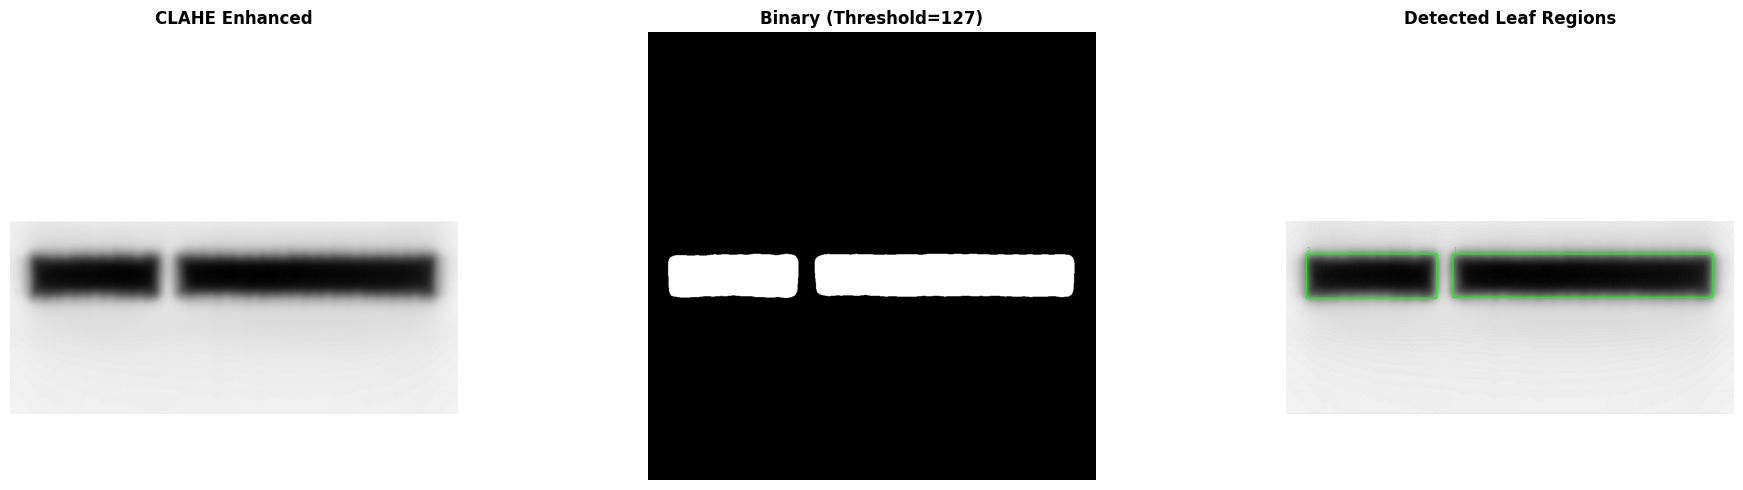

In [4]:
# Detection parameters
tolerance_threshold = 127  # Binary threshold at 50% (pixels darker than half are counted as black)
tolerance_kernel_size = 3  # Morphological operations kernel
min_area = 200  # Minimum contour area in pixels
merge_distance_px = 40  # Distance for merging nearby contours

# Create binary image from CLAHE enhanced image
# Threshold at 127 (50% of 255) - pixels darker than this are considered black
_, binary_image = cv2.threshold(clahe_img, tolerance_threshold, 255, cv2.THRESH_BINARY_INV)

# Apply morphological operations to clean up regions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (tolerance_kernel_size, tolerance_kernel_size))
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = [c for c in contours if cv2.contourArea(c) > min_area]

print(f"\n" + "="*80)
print("CONTOUR DETECTION")
print("="*80)
print(f"Initial contours found: {len(contours)}")

# Merge nearby contours
def merge_nearby_contours(contours, merge_distance_px=30):
    """Merge contours that are close to each other (fragmented parts of same leaf)"""
    if len(contours) <= 1:
        return contours
    
    # Get bounding rectangles and centers for all contours
    contour_data = []
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        cx = x + w / 2
        cy = y + h / 2
        contour_data.append({
            'index': i,
            'contour': contour,
            'bbox': (x, y, w, h),
            'center': (cx, cy),
            'merged': False
        })
    
    merged_contours = []
    
    for i, data_i in enumerate(contour_data):
        if data_i['merged']:
            continue
            
        close_contours = [data_i['contour']]
        data_i['merged'] = True
        
        for j, data_j in enumerate(contour_data):
            if i == j or data_j['merged']:
                continue
                
            # Calculate distance between centers
            dx = data_i['center'][0] - data_j['center'][0]
            dy = data_i['center'][1] - data_j['center'][1]
            distance = np.sqrt(dx**2 + dy**2)
            
            # Check if vertically aligned (same row)
            vertical_alignment = abs(dy) < 15
            
            # Merge if close and aligned
            if distance < merge_distance_px and vertical_alignment:
                close_contours.append(data_j['contour'])
                data_j['merged'] = True
        
        # Merge multiple close contours
        if len(close_contours) > 1:
            mask = np.zeros(binary_image.shape, dtype=np.uint8)
            for contour in close_contours:
                cv2.fillPoly(mask, [contour], 255)
            
            merged_contours_temp, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if merged_contours_temp:
                merged_contours.append(merged_contours_temp[0])
        else:
            merged_contours.append(close_contours[0])
    
    return merged_contours

# Apply merging
merged_contours = merge_nearby_contours(contours, merge_distance_px=merge_distance_px)
contours = [c for c in merged_contours if cv2.contourArea(c) > min_area]

print(f"After merging: {len(contours)} contours")
print(f"Settings: threshold={tolerance_threshold}, min_area={min_area}, merge_distance={merge_distance_px}px")
print("="*80)

# Visualize contours
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(clahe_img, cmap='gray')
axes[0].set_title('CLAHE Enhanced', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(binary_image, cmap='gray')
axes[1].set_title(f'Binary (Threshold={tolerance_threshold})', fontweight='bold')
axes[1].axis('off')

image_with_boxes = cv2.cvtColor(laplacian_sharpened, cv2.COLOR_GRAY2BGR)
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image_with_boxes, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

axes[2].imshow(image_with_boxes)
axes[2].set_title('Detected Leaf Regions', fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 5. Individual Leaf Detection (28 Leaves)


INDIVIDUAL LEAF DETECTION (28 LEAVES: 27-54)
Leaf Width: 7.18 mm at isocenter = 33.25 pixels
Field Width: 929.00 pixels
Horizontal Padding: 0 pixels

Total Leaves: 28
Detected Leaves: 27
Retracted Leaves: 1
Retracted Leaf Numbers: [36]

Normalization Reference Point M:
  Image Coordinates: u=511.03 px, v=625.70 px
  Patient Coordinates: X=-0.59 mm, Y=455.28 mm
  Isocenter Coordinates (raw): X=-0.32 mm, Y=245.81 mm
  Y Offset Applied: -245.81 mm (to align M at Y=0 mm)

Leaf #   Status       Top Y (mm)      Bottom Y (mm)  
--------------------------------------------------
27       Detected     -24.12          -4.69          
28       Detected     -24.12          -4.47          
29       Detected     -24.34          -4.69          
30       Detected     -24.77          -4.69          
31       Detected     -24.77          -4.90          
32       Detected     -24.77          -4.69          
33       Detected     -24.77          -4.47          
34       Detected     -24.34          -4.69

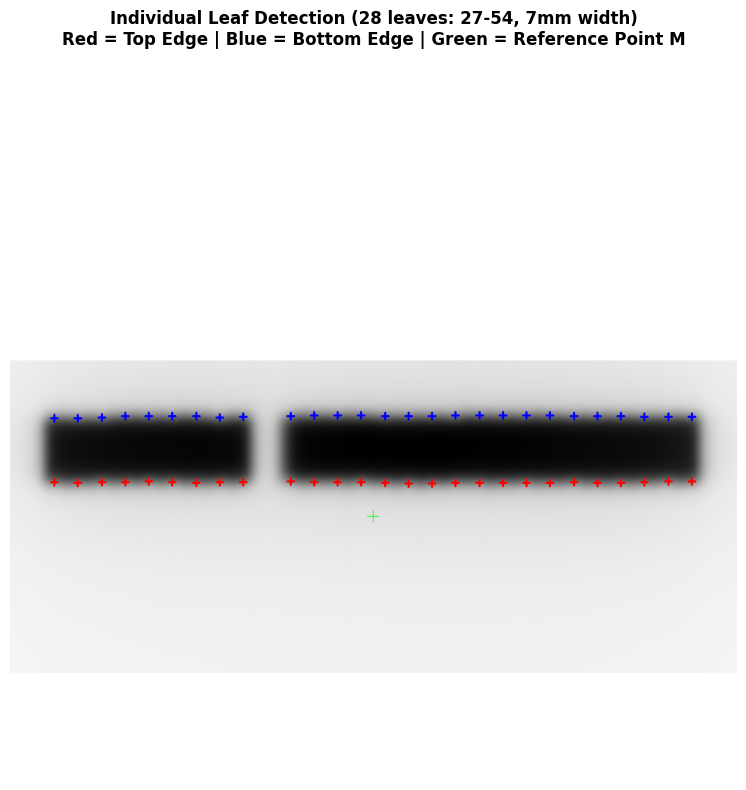

In [354]:
# Leaf detection parameters
num_leaves = 28  # Fixed number of MLC leaves
leaf_width_iso = 7.18  # mm at isocenter (FIXED specification)
leaf_detection_threshold = 115  # Binary threshold for edge detection lower=more sensitive)
horizontal_padding_pixels = 0  # Horizontal padding to extend/shrink detection region (can be negative)

leaf_numbers = list(range(27, 55))  # [27, 28, 29, ..., 53, 54]

# Create binary image for leaf edge detection (simple threshold method)
_, binary_image_leaves = cv2.threshold(img_8bit, leaf_detection_threshold, 255, cv2.THRESH_BINARY_INV)

if len(contours) > 0:
    print("\n" + "="*80)
    print("INDIVIDUAL LEAF DETECTION (28 LEAVES: 27-54)")
    print("="*80)
    
    # Calculate leaf width at image plane
    leaf_width_image_plane = leaf_width_iso / scaling_factor  # mm at image plane
    leaf_width_pixels = leaf_width_image_plane / pixel_spacing_x  # pixels
    
    # Find field boundaries from all detected regions (horizontal padding on LEFT side only)
    all_x_min = max(0, min([cv2.boundingRect(c)[0] for c in contours]) - horizontal_padding_pixels)
    all_x_max = min(image_array.shape[1], max([cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2] for c in contours]))
    all_y_min = max(0, min([cv2.boundingRect(c)[1] for c in contours]))
    all_y_max = min(image_array.shape[0], max([cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3] for c in contours]))
    
    field_width_pixels = all_x_max - all_x_min
    
    print(f"Leaf Width: {leaf_width_iso:.2f} mm at isocenter = {leaf_width_pixels:.2f} pixels")
    print(f"Field Width: {field_width_pixels:.2f} pixels")
    print(f"Horizontal Padding: {horizontal_padding_pixels} pixels")
    
    # Visualization image - use original 8-bit image to maintain size
    leaf_detection_image = cv2.cvtColor(img_8bit.copy(), cv2.COLOR_GRAY2BGR)
    
    # Store leaf edge positions (always 28 leaves)
    leaf_edges = []
    
    for leaf_idx in range(num_leaves):
        leaf_number = leaf_numbers[leaf_idx]  # Get actual leaf number from sequence just in case if not 28 
        leaf_x_center = all_x_min + (leaf_idx + 0.5) * leaf_width_pixels
        leaf_x_start = int(all_x_min + leaf_idx * leaf_width_pixels)
        leaf_x_end = int(all_x_min + (leaf_idx + 1) * leaf_width_pixels)
        
        # Extract vertical column for this leaf
        leaf_column = binary_image_leaves[all_y_min:all_y_max, leaf_x_start:leaf_x_end]
        black_pixels = np.where(leaf_column > 0)

        if len(black_pixels[0]) > 0:
            # Leaf detected - get top and bottom edges
            top_y_relative = np.min(black_pixels[0])
            bottom_y_relative = np.max(black_pixels[0])
            
            # Check if the leaf height is at least 10 pixels (otherwise considered retracted)
            leaf_height_pixels = bottom_y_relative - top_y_relative
            # print("HERE IS LEAF HEIGHT ", leaf_height_pixels)
            
            if leaf_height_pixels >= 10:
                # Valid leaf detection
                top_y_absolute = all_y_min + top_y_relative
                bottom_y_absolute = all_y_min + bottom_y_relative
                # Convert to mm coordinates (patient reference frame)
                top_y_mm = rt_image_pos_y + (top_y_absolute * pixel_spacing_y)
                bottom_y_mm = rt_image_pos_y + (bottom_y_absolute * pixel_spacing_y)
                
                # Convert to isocenter coordinates
                top_y_iso = top_y_mm * scaling_factor
                bottom_y_iso = bottom_y_mm * scaling_factor
                
                leaf_edges.append({
                    'leaf': leaf_number,
                    'x_px': leaf_x_center,
                    'top_y_px': top_y_absolute,
                    'bottom_y_px': bottom_y_absolute,
                    'top_y_iso': top_y_iso,
                    'bottom_y_iso': bottom_y_iso,
                    'retracted': False
                })
                
                # Draw detection crosses
                cross_size = 5
                # Top edge (red)
                cv2.line(leaf_detection_image, 
                        (int(leaf_x_center) - cross_size, top_y_absolute), 
                        (int(leaf_x_center) + cross_size, top_y_absolute), 
                        (0, 0, 255), 2)
                cv2.line(leaf_detection_image, 
                        (int(leaf_x_center), top_y_absolute - cross_size), 
                        (int(leaf_x_center), top_y_absolute + cross_size), 
                        (0, 0, 255), 2)
                
                # Bottom edge (blue)
                cv2.line(leaf_detection_image, 
                        (int(leaf_x_center) - cross_size, bottom_y_absolute), 
                        (int(leaf_x_center) + cross_size, bottom_y_absolute), 
                        (255, 0, 0), 2)
                cv2.line(leaf_detection_image, 
                        (int(leaf_x_center), bottom_y_absolute - cross_size), 
                        (int(leaf_x_center), bottom_y_absolute + cross_size), 
                        (255, 0, 0), 2)
            else:
                # Leaf height too small - considered retracted
                leaf_edges.append({
                    'leaf': leaf_number,
                    'x_px': leaf_x_center,
                    'top_y_px': None,
                    'bottom_y_px': None,
                    'top_y_iso': None,
                    'bottom_y_iso': None,
                    'retracted': True
                })
        else:
            # Leaf retracted (no pixels detected)
            leaf_edges.append({
                'leaf': leaf_number,
                'x_px': leaf_x_center,
                'top_y_px': None,
                'bottom_y_px': None,
                'top_y_iso': None,
                'bottom_y_iso': None,
                'retracted': True
            })
    
    # Count detected and retracted leaves
    detected_leaves = [leaf for leaf in leaf_edges if not leaf['retracted']]
    retracted_leaves = [leaf for leaf in leaf_edges if leaf['retracted']]
    
    print(f"\nTotal Leaves: {len(leaf_edges)}")
    print(f"Detected Leaves: {len(detected_leaves)}")
    print(f"Retracted Leaves: {len(retracted_leaves)}")
    if len(retracted_leaves) > 0:
        retracted_nums = [leaf['leaf'] for leaf in retracted_leaves]
        print(f"Retracted Leaf Numbers: {retracted_nums}")
    
    # Normalize coordinates using fixed reference point M
    if len(detected_leaves) > 0:
        # Fixed reference point M in image coordinates (pixels)
        ref_point_u = 511.03  # X coordinate in pixels
        ref_point_v = 625.7   # Y coordinate in pixels
        
        # Convert reference point to mm coordinates (patient reference frame)
        ref_point_mm_x = rt_image_pos_x + (ref_point_u * pixel_spacing_x)
        ref_point_mm_y = rt_image_pos_y + (ref_point_v * pixel_spacing_y)
        
        # Convert to isocenter coordinates
        ref_point_iso_x = ref_point_mm_x * scaling_factor
        ref_point_iso_y = ref_point_mm_y * scaling_factor
        
        # Target reference values - reference point M should be at (0, 0) at isocenter
        target_ref_y = 0.0  # Reference point Y at 0 mm
        
        # Calculate normalization offset based on reference point M
        offset_y = target_ref_y - ref_point_iso_y
        
        print(f"\nNormalization Reference Point M:")
        print(f"  Image Coordinates: u={ref_point_u:.2f} px, v={ref_point_v:.2f} px")
        print(f"  Patient Coordinates: X={ref_point_mm_x:.2f} mm, Y={ref_point_mm_y:.2f} mm")
        print(f"  Isocenter Coordinates (raw): X={ref_point_iso_x:.2f} mm, Y={ref_point_iso_y:.2f} mm")
        print(f"  Y Offset Applied: {offset_y:.2f} mm (to align M at Y=0 mm)")
        
        # Apply normalization
        print(f"\n{'Leaf #':<8} {'Status':<12} {'Top Y (mm)':<15} {'Bottom Y (mm)':<15}")
        print("-" * 50)
        
        for leaf in leaf_edges:
            if not leaf['retracted']:
                # Apply single offset to both top and bottom (reference point M normalization)
                leaf['top_y_normalized'] = leaf['top_y_iso'] + offset_y
                leaf['bottom_y_normalized'] = leaf['bottom_y_iso'] + offset_y
                
                print(f"{leaf['leaf']:<8} {'Detected':<12} {leaf['top_y_normalized']:<15.2f} {leaf['bottom_y_normalized']:<15.2f}")
            else:
                leaf['top_y_normalized'] = None
                leaf['bottom_y_normalized'] = None
                print(f"{leaf['leaf']:<8} {'RETRACTED':<12} {'N/A':<15} {'N/A':<15}")
        
        print("-" * 50)
        
        # Display X=0 alignment summary
        print(f"\n{'='*80}")
        print("ISOCENTER ALIGNMENT (X=0, Y coordinates)")
        print(f"{'='*80}")
        print(f"Reference Point M: X=0.00 mm, Y=0.00 mm (normalized)")
        print(f"\n{'Leaf #':<10} {'Top Y (mm)':<15} {'Bottom Y (mm)':<15} {'Status':<12}")
        print("-" * 52)
        
        for leaf in leaf_edges:
            if not leaf['retracted']:
                print(f"{leaf['leaf']:<10} {leaf['top_y_normalized']:<15.2f} {leaf['bottom_y_normalized']:<15.2f} {'Active':<12}")
            else:
                print(f"{leaf['leaf']:<10} {'N/A':<15} {'N/A':<15} {'Retracted':<12}")
        
        print("-" * 52)
        print(f"Note: All coordinates are at isocenter with X=0 mm (center alignment)")
        print(f"{'='*80}")
    
    # Draw reference point M on the visualization
    ref_point_u = 511.03
    ref_point_v = 652.75
    cross_size = 8
    cross_color_ref = (0, 255, 0)  # Green for reference point M
    
    cv2.line(leaf_detection_image, 
            (int(ref_point_u) - cross_size, int(ref_point_v)), 
            (int(ref_point_u) + cross_size, int(ref_point_v)), 
            cross_color_ref, 1)
    cv2.line(leaf_detection_image, 
            (int(ref_point_u), int(ref_point_v) - cross_size), 
            (int(ref_point_u), int(ref_point_v) + cross_size), 
            cross_color_ref, 1)
    
    # Display visualization
    plt.figure(figsize=(14, 8))
    plt.imshow(leaf_detection_image)
    plt.title('Individual Leaf Detection (28 leaves: 27-54, 7mm width)\nRed = Top Edge | Blue = Bottom Edge | Green = Reference Point M', 
             fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("="*80)
else:
    print("\n⚠️  No contours detected! Cannot perform leaf detection.")